# The hippocampus as a predictive map
Kimberly L Stachenfeld, Matthew M Botvinick & Samuel J Gershman 

https://www.nature.com/articles/nn.4650

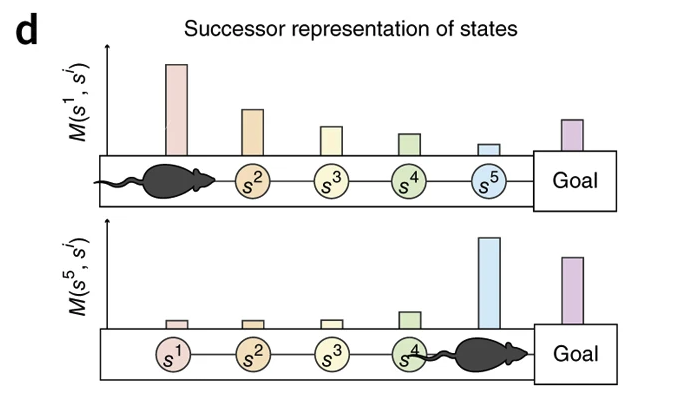

In this notbook we provide easy example on how to run the Succesor Representation (SR) model presented in the paper 'The hippocampus as a predictive map  model'. 
The model is run in multiple different types of environements both generic and build from experimental data.

In [1]:
import sys
sys.path.append("../")
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from tqdm import tqdm
from neuralplayground.arenas import Simple2D, MergingRoom, Sargolini2006, Hafting2008, BasicSargolini2006,Wernle2018
from neuralplayground.utils import create_circular_wall
from neuralplayground.agents import  Stachenfeld2018


## Initialise the arena

We first create a random 2D arena for the agent to interact with. For more information on how to create arena refer to the arena jupyter notebook.

In [2]:
room_width = [-6,6]
room_depth = [-6,6]
env_name = "env_example"
time_step_size = 0.2
agent_step_size = 1
# Init environment
env = Simple2D(environment_name=env_name,
               arena_x_limits = room_width,
               arena_y_limits = room_depth,
               time_step_size = time_step_size,
               agent_step_size = agent_step_size)


## Initialise the SR agent

In [3]:
discount = .9
threshold = 1e-6
lr_td = 1e-2
t_episode = 1000
n_episode = 1000
state_density = int(1 / agent_step_size)
agent =  Stachenfeld2018(discount=discount, t_episode=t_episode, n_episode=n_episode, threshold=threshold, lr_td=lr_td,
               room_width=env.room_width, room_depth=env.room_depth, state_density=state_density,twoD=True)

If we assume we know the transition matrix  $T_t(s,s′)$ is the probability of transitioning from s to s′ in exactly t step, one can compute the successor representation using successive additive update

$$ M= \sum_{t=0}^{\infty} \gamma^tT^t $$

We use this as sanity check for our results bellow. 

In [4]:
sr_sum= agent.successor_rep_sum()

We plot the transition matrix and the eigenvectors of the Successor Matrix $M$. Choose an array of four eigenvectors you would like to plot. 

<Axes: >

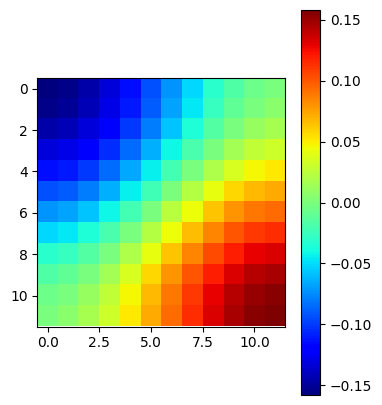

In [9]:
agent.plot_eigen(sr_sum, eigen=[1],save_path=None)


One can compute the successor representation matrix using geometric sums for $\gamma<1$
$$ M= \sum_{t=0}^{\infty} \gamma^tT^t =(I-\gamma T)^{-1}$$

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

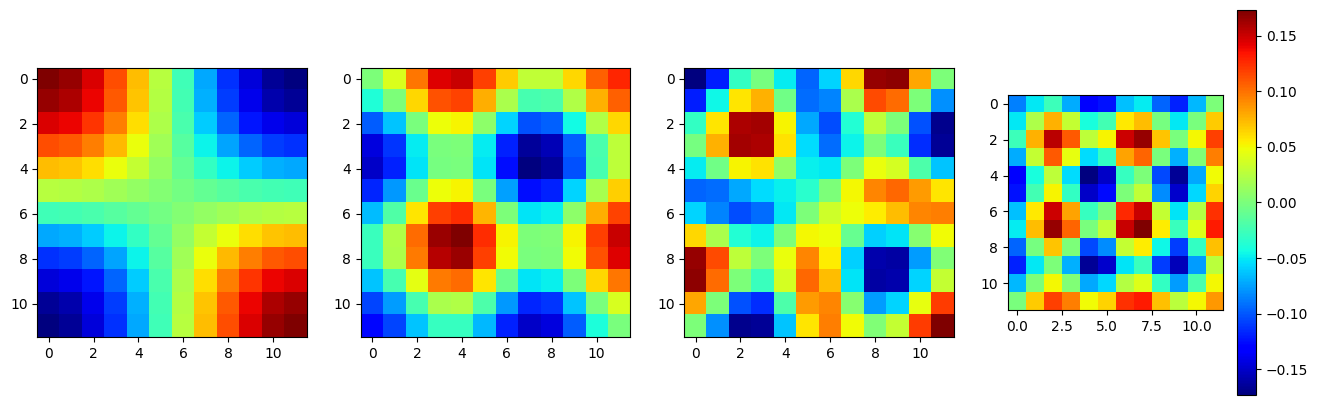

In [11]:
sr = agent.update_successor_rep()  
agent.plot_eigen(sr, eigen=[1,10,15,20],save_path=None)

Compute the successor representation matrix using TD learning

$$ M_{t+1}(s_t,s')= M_{t}(s_t,s')+\eta[I(s_t=s')+\gamma M_t(s_{t+1},s')-M_t(s_t,s')] $$

In [7]:
# Choose your function depending on the type of env '2D_env' or '1D_env' 
# Only run if twoDvalue=True
sr_td = agent.update_successor_rep_td_full()  
agent.plot_eigen(sr_td,eigen=[1,10,15,20], save_path=None)


KeyboardInterrupt



## Agent and Arena Interaction

The agent receives observations from the environment (reward, visual cues, etc.) and uses these to take an action with the function ``` act```  which in turn will ``` update```  both its state and the state of the environment, generating new observations ```env.step``` . We plot

We note that the SR model is a discrete model as opposed to the arena which is continous. The discretization is done within the agent concidering that the state representation is build by the agent.

In [ ]:
plot_every = 1000*100
total_iters = 0
obs, state = env.reset()
for i in tqdm(range(n_episode)):
    for j in range(t_episode):
        action = agent.act(obs)  # the action is link to density of state to make sure we always land in a new
        K  = agent.update()
        obs, state, reward = env.step(action)
        obs = obs[:2]
        total_iters += 1
        if total_iters % plot_every == 0:
            agent.plot_eigen(K, eigen=[1,10,15,20],save_path='./sr.png')


Plotting the ground truth transition matrix and the transition matrix resulting from the interaction with the environment.

In [ ]:
T = agent.get_T_from_M(K)
agent.plot_transition(T, save_path=None)

Circular Arena

In [ ]:
class CircularArena(Simple2D):
    
    def _create_custom_walls(self):
        self.custom_walls = create_circular_wall(center=np.array([0, 0]), radius=50)  # One inner circle
        self.custom_walls += create_circular_wall(center=np.array([0, 0]), radius=75)  # One outer circle

In [ ]:
time_step_size = 1 #seg
agent_step_size = 1
arena_x_limits = np.array((-100, 100))
arena_y_limits = np.array((-100, 100))

# Init environment
env = CircularArena(time_step_size = time_step_size,
                    agent_step_size = agent_step_size,
                    arena_x_limits=arena_x_limits,
                    arena_y_limits=arena_y_limits)

In [ ]:
discount = .9
threshold = 1e-6
lr_td = 1e-2
t_episode = 100
n_episode = 100
state_density = int(1 / agent_step_size)
agent =  Stachenfeld2018(discount=discount, t_episode=t_episode, n_episode=n_episode, threshold=threshold, lr_td=lr_td,
               room_width=env.room_width, room_depth=env.room_depth, state_density=state_density,twoD=True)

We do not expect that have good grid cells here as the state covers the all arena. One can concider building specific state space strucutre that is not 2D.

In [ ]:
plot_every = 1000
total_iters = 0
obs, state = env.reset(custom_state=[-70,0])
for i in tqdm(range(n_episode)):
    for j in range(t_episode):
        action = agent.act(obs)  # the action is link to density of state to make sure we always land in a new
        K  = agent.update()
        obs, state, reward = env.step(action)
        obs = obs[:2]
        total_iters += 1
        if total_iters % plot_every == 0:
            agent.plot_eigen(K, eigen=[1,10,15,20],save_path=None)

In [ ]:
ax = env.plot_trajectory()
fontsize = 16
ax.grid()
# ax.legend(fontsize=fontsize, loc="upper left")
ax.set_xlabel("width", fontsize=fontsize)
ax.set_ylabel("depth", fontsize=fontsize)
plt.savefig("circle.pdf", bbox_inches="tight")
plt.show()

## Experimental arenas

### Sargolini et al, 2006

We start with the data set from *Conjunctive Representation of Position, Direction, and Velocity in Entorhinal Cortex*, Sargolini et al 2006 (https://www.science.org/doi/10.1126/science.1125572)

Here we use the real behaviour data of the experiment.
Default is False and runs a random agent.

In [ ]:
data_path = data_path = "../../neuralplayground/experiments/sargolini_2006/"
env = BasicSargolini2006(use_behavioral_data=True, data_path=data_path,
                         time_step_size=0.1,
                         agent_step_size=None)
    

Initialise the agent in this new environement

In [ ]:
agent_step_size = 10
discount = .9
threshold = 1e-6
lr_td = 1e-2
t_episode = 1000
n_episode = 100
state_density = (1 / agent_step_size)
twoDvalue = True

agent = Stachenfeld2018(discount=discount, t_episode=t_episode, n_episode=n_episode, threshold=threshold, lr_td=lr_td,
               room_width=env.room_width, room_depth=env.room_depth, state_density=state_density, twoD=twoDvalue)



In [ ]:
sr = agent.update_successor_rep() # One can compute the successor representation using successive additive update

agent.plot_eigen(sr,eigen=[1,10,15,20], save_path=None)

sr_td = agent.update_successor_rep_td_full() # Compute the successor representation matrix using TD learning
agent.plot_eigen(sr_td, eigen=[1,10,15,20],save_path=None)

sr_sum = agent.successor_rep_sum() # One can compute the successor representation matrix using geometric sums for $\gamma<1$
agent.plot_eigen(sr_sum, eigen=[1,10,15,20],save_path=None)


Agent and Arena Interaction

In [ ]:
plot_every = 10000
total_iters = 0
obs, state = env.reset()
obs = obs[:2]
for i in tqdm(range(10000)):
# Observe to choose an action
    action = agent.act(obs)  # the action is link to density of state to make sure we always land in a new
    K  = agent.update()
    obs, state, reward = env.step(action)
    obs= obs[:2]
    total_iters += 1
    if total_iters % plot_every == 0:
        agent.plot_eigen(K,eigen=[1,10,15,20], save_path='./sr_sargo.png')

Plotting the ground truth transition matrix and the transition matrix resulting from the interaction with the environment.

In [ ]:
T = agent.get_T_from_M(K)
agent.plot_transition(T, save_path=None)

In [ ]:
ax = env.plot_trajectory()
fontsize = 16
ax.grid()
# ax.legend(fontsize=fontsize, loc="upper left")
ax.set_xlabel("width", fontsize=fontsize)
ax.set_ylabel("depth", fontsize=fontsize)
plt.savefig("circle.pdf", bbox_inches="tight")
plt.show()

### Hafting et al, 2008

Let's look at *Hippocampus-independent phase precession in entorhinal grid cells* by Hafting et al 2008 (https://www.nature.com/articles/nature06957)

In [ ]:
env = Hafting2008(use_behavioral_data=True,time_step_size=0.1,
                         agent_step_size=None)
    

Initialise the agent in this new environement

In [ ]:
agent_step_size = 10
discount = .9
threshold = 1e-6
lr_td = 1e-2
t_episode = 1000
n_episode = 100
state_density = (1 / agent_step_size)
twoDvalue = True

agent = Stachenfeld2018(discount=discount, t_episode=t_episode, n_episode=n_episode, threshold=threshold, lr_td=lr_td,
               room_width=env.room_width, room_depth=env.room_depth, state_density=state_density, twoD=twoDvalue)



In [ ]:
sr = agent.update_successor_rep() # One can compute the successor representation using successive additive update

agent.plot_eigen(sr,eigen=[1,5,10,15], save_path=None)

sr_td = agent.update_successor_rep_td_full() # Compute the successor representation matrix using TD learning
agent.plot_eigen(sr_td, eigen=[1,5,10,15],save_path='./sr_Hating.png')

sr_sum = agent.successor_rep_sum() # One can compute the successor representation matrix using geometric sums for $\gamma<1$
agent.plot_eigen(sr_sum, eigen=[1,5,10,15],save_path=None)


Agent and Arena Interaction

In [ ]:
plot_every = 1000000
total_iters = 0
obs, state = env.reset()
obs = obs[:2]
for i in tqdm(range(100000000)):
# Observe to choose an action
    action = agent.act(obs)  # the action is link to density of state to make sure we always land in a new
    K  = agent.update()
    obs, state, reward = env.step(action)
    obs= obs[:2]
    total_iters += 1
    if total_iters % plot_every == 0:
        agent.plot_eigen(K,eigen=[1,10,15,20], save_path='./sr_Hating.png')

In [ ]:
print(env.room_depth)

Plotting the ground truth transition matrix and the transition matrix resulting from the interaction with the environment.

In [ ]:
T = agent.get_T_from_M(K)
agent.plot_transition(T, save_path=None)

In [ ]:
ax = env.plot_trajectory()
plt.show()

### Wernle et al, 2018

- *Integration of grid maps in merged environments*, Wernle et al. 2018 (https://www.nature.com/articles/s41593-017-0036-6)

In [ ]:
time_step_size = 0.2
agent_step_size = 5.0
merging_time = 240  # Time in minutes to remove 
switch_time = 120 # Time in minutes to move the mouse to the other side of the arena
n_steps = ((merging_time + switch_time)*60) / time_step_size
fontsize = 16

env = Wernle2018(use_behavioral_data=True,merge_time=merging_time,
                 switch_time=switch_time,
                 time_step_size=time_step_size,
                 agent_step_size=agent_step_size)

Initialise the agent in this new environement

In [ ]:
agent_step_size = 10
discount = .9
threshold = 1e-6
lr_td = 1e-2
t_episode = 1000
n_episode = 100
state_density = (1 / agent_step_size)
twoDvalue = True

agent = Stachenfeld2018(discount=discount, t_episode=t_episode, n_episode=n_episode, threshold=threshold, lr_td=lr_td,
               room_width=env.room_width, room_depth=env.room_depth, state_density=state_density, twoD=twoDvalue)



Agent and Arena interaction

In [ ]:
obs, state = env.reset()

print(obs)

for j in range(round(n_steps)):
    # Observe to choose an action
    action = agent.act(obs)
    print(action)# the action is link to density of state to make sure we always land in a new
    K  = agent.update()
    obs, state, reward = env.step(action)
    obs= obs[:2]
    # We plot the trajectory of the agent just right before the merge
    # then we keep running the loop
    if j == int((merging_time*60)/time_step_size)-1:
        ax = env.plot_trajectory()
        ax.set_xlabel("width", fontsize=fontsize)
        ax.set_ylabel("depth", fontsize=fontsize)
        plt.savefig("pre_merge.pdf", bbox_inches="tight")
        agent.plot_rates()




Agent and Arena Interaction

In [ ]:
plot_every = 1000000
total_iters = 0
obs, state = env.reset()
obs = obs[:2]
for i in tqdm(range(1000000)):
# Observe to choose an action
    action = agent.act(obs)  # the action is link to density of state to make sure we always land in a new
    K  = agent.update()
    obs, state, reward = env.step(action)
    obs= obs[:2]
    total_iters += 1
    if total_iters % plot_every == 0:
        agent.plot_eigen(K,eigen=[1,10,15,20], save_path=None)

Plotting the ground truth transition matrix and the transition matrix resulting from the interaction with the environment.

In [ ]:
T = agent.get_T_from_M(K)
agent.plot_transition(T, save_path=None)

##  To Save

In [ ]:
sr_td = agent.update_successor_rep_td_full() # Compute the successor representation matrix using TD learning
agent.plot_eigen(sr_td, eigen=[1,10,15,20], save_path='./sr.png')

# Merging Rooms

In [ ]:

time_step_size = 0.2
merging_time = 240*2.0  # Time in minutes to remove 
switch_time = 240.0 # Time in minutes to move the mouse to the other side of the arena
additional_time = 240.0

n_steps = ((merging_time + switch_time + additional_time)*60) / time_step_size
fontsize = 16

room_width = [-10,10]
room_depth = [-10,10]
env_name = "merging_room"

# Init environment
env = MergingRoom(arena_x_limits = room_width,
                  arena_y_limits = room_depth,
                  time_step_size = time_step_size,
                  agent_step_size = agent_step_size,
                  merge_time = merging_time,
                  switch_time = switch_time)

agent_step_size = 1
discount = .9
threshold = 1e-6
lr_td = 1e-2
t_episode = 1000
n_episode = 100
state_density = (1 / agent_step_size)
twoDvalue = True

agent = Stachenfeld2018(discount=discount, t_episode=t_episode, n_episode=n_episode, threshold=threshold, lr_td=lr_td,
               room_width=env.room_width, room_depth=env.room_depth, state_density=state_density, twoD=twoDvalue)



In [ ]:
obs, state = env.reset(custom_state=[-2,2])

for j in tqdm(range(round(n_steps))):
    # Observe to choose an action
    #action = agent.act(obs, policy_func=policy_agent.act)
    action = agent.act(obs)
    # Run environment for given action
    obs, state, reward = env.step(action)
    print(obs)
    agent.update()
    # We plot the trajectory of the agent just right before the merge
    # then we keep running the loop
    if j == int((switch_time*60)/time_step_size)-1:
        ax = env.plot_trajectory(plot_every=100)
        ax.set_xlabel("width", fontsize=fontsize)
        ax.set_ylabel("depth", fontsize=fontsize)
        agent.save_agent("pre_switch.agent")
        agent.plot_rates()
        plt.savefig("pre_switch.pdf", bbox_inches="tight")
    if j == int((merging_time*60)/time_step_size)-1:
        ax = env.plot_trajectory(plot_every=100)
        ax.set_xlabel("width", fontsize=fontsize)
        ax.set_ylabel("depth", fontsize=fontsize)
        agent.plot_rates()
        plt.savefig("pre_merge.pdf", bbox_inches="tight")
        agent.save_agent("pre_merge.agent")
agent.save_agent("post_merge.agent")

In [ ]:
# Here we take the section of interaction history for the period after the merge
merged_history = env.history[int((merging_time*60)/time_step_size):]
# Note that the wall is already removed from the arena structure
ax = env.plot_trajectory(history_data=merged_history, plot_every=100)
ax.set_xlabel("width", fontsize=fontsize)
ax.set_ylabel("depth", fontsize=fontsize)

agent.plot_rates()
plt.savefig("post_merge.pdf", bbox_inches="tight")